# Homework 4

This assignment covers seam carving for the purpose of content-aware resizing.

The material presented here is inspired from:
- paper on seam carving: http://graphics.cs.cmu.edu/courses/15-463/2007_fall/hw/proj2/imret.pdf
- tutorial: http://cs.brown.edu/courses/cs129/results/proj3/taox
- tutorial: http://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/f07/proj2/www/wwedler/

Don't hesitate to check these links if you have any doubt on the seam carving process.

The whole seam carving process was covered in [lecture 7](http://vision.stanford.edu/teaching/cs131_fall1920/slides/07_seam_carving.pdf), please refer to the slides for more details to the different concepts introduced here.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import color

from time import time
from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

<Figure size 1332x756 with 0 Axes>

## Image Reducing using Seam Carving

Seam carving is an algorithm for content-aware image resizing.  
To understand all the concepts in this homework, make sure to read again the slides from lecture 7: http://vision.stanford.edu/teaching/cs131_fall1920/slides/07_seam_carving.pdf

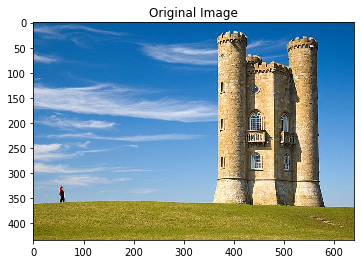

In [2]:
from skimage import io, util

# Load image
img = io.imread('imgs/broadway_tower.jpg')
img = util.img_as_float(img)

plt.title('Original Image')
plt.imshow(img)
plt.show()

### Energy function (5 points)
We will now implemented the `energy_function` to compute the energy of the image.  
The energy at each pixel is the sum of:
- absolute value of the gradient in the $x$ direction
- absolute value of the gradient in the $y$ direction


The function should take around 0.01 to 0.1 seconds to compute.

In [3]:
from seam_carving import energy_function

test_img = np.array([[1.0, 2.0, 1.5],
                     [3.0, 1.0, 2.0],
                     [4.0, 0.5, 3.0]])
test_img = np.stack([test_img] * 3, axis=2)
assert test_img.shape == (3, 3, 3)

# Compute energy function
test_energy = energy_function(test_img)

solution_energy = np.array([[3.0, 1.25,  1.0],
                            [3.5, 1.25, 1.75],
                            [4.5,  1.0,  3.5]])

print("Image (channel 0):")
print(test_img[:, :, 0])

print("Energy:")
print(test_energy)
print("Solution energy:")
print(solution_energy)

assert np.allclose(test_energy, solution_energy)

Image (channel 0):
[[1.  2.  1.5]
 [3.  1.  2. ]
 [4.  0.5 3. ]]
Energy:
[[3.   1.25 1.  ]
 [3.5  1.25 1.75]
 [4.5  1.   3.5 ]]
Solution energy:
[[3.   1.25 1.  ]
 [3.5  1.25 1.75]
 [4.5  1.   3.5 ]]


Computing energy function: 0.007276 seconds.


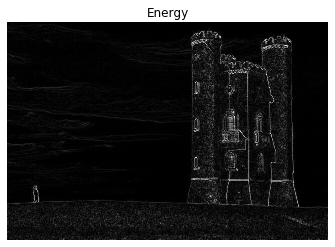

In [4]:
# Compute energy function
start = time()
energy = energy_function(img)
end = time()

print("Computing energy function: %f seconds." % (end - start))

plt.title('Energy')
plt.axis('off')
plt.imshow(energy)
plt.show()

### Compute cost (10 points)

Now implement the function `compute_cost`.
Starting from the energy map, we'll go from the first row of the image to the bottom and compute the minimal cost at each pixel.

We'll use dynamic programming to compute the cost line by line starting from the first row.

The function should take around 0.05 seconds to complete.

In [5]:
from seam_carving import compute_cost

# Let's first test with a small example

test_energy = np.array([[1.0, 2.0, 1.5],
                        [3.0, 1.0, 2.0],
                        [4.0, 0.5, 3.0]])

solution_cost = np.array([[1.0, 2.0, 1.5],
                          [4.0, 2.0, 3.5],
                          [6.0, 2.5, 5.0]])

solution_paths = np.array([[ 0,  0,  0],
                           [ 0, -1,  0],
                           [ 1,  0, -1]])

# Vertical Cost Map
vcost, vpaths = compute_cost(_, test_energy, axis=1)  # don't need the first argument for compute_cost

print("Energy:")
print(test_energy)

print("Cost:")
print(vcost)
print("Solution cost:")
print(solution_cost)

print("Paths:")
print(vpaths)
print("Solution paths:")
print(solution_paths)

Energy:
[[1.  2.  1.5]
 [3.  1.  2. ]
 [4.  0.5 3. ]]
Cost:
[[1.  2.  1.5]
 [4.  2.  3.5]
 [6.  2.5 5. ]]
Solution cost:
[[1.  2.  1.5]
 [4.  2.  3.5]
 [6.  2.5 5. ]]
Paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 1  0 -1]]
Solution paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 1  0 -1]]


Computing vertical cost map: 0.024265 seconds.


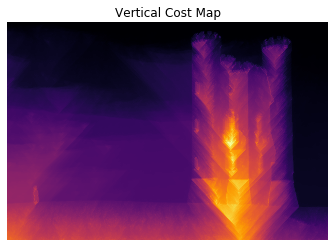

In [6]:
# Vertical Cost Map
start = time()
vcost, _ = compute_cost(_, energy, axis=1)  # don't need the first argument for compute_cost
end = time()

print("Computing vertical cost map: %f seconds." % (end - start))

plt.title('Vertical Cost Map')
plt.axis('off')
plt.imshow(vcost, cmap='inferno')
plt.show()

Computing horizontal cost map: 0.032933 seconds.


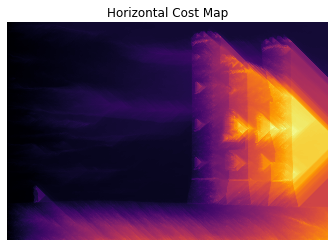

In [7]:
# Horizontal Cost Map
start = time()
hcost, _ = compute_cost(_, energy, axis=0)
end = time()

print("Computing horizontal cost map: %f seconds." % (end - start))

plt.title('Horizontal Cost Map')
plt.axis('off')
plt.imshow(hcost, cmap='inferno')
plt.show()

## Finding optimal seams

Using the cost maps we found above, we can determine the seam with the lowest energy in the image.  
We can then remove this optimal seam, and repeat the process until we obtain a desired width.

### Backtrack seam (5 points)

Implement function `backtrack_seam`.

In [8]:
from seam_carving import backtrack_seam

# Let's first test with a small example
cost = np.array([[1.0, 2.0, 1.5],
                 [4.0, 2.0, 3.5],
                 [6.0, 2.5, 5.0]])

paths = np.array([[ 0,  0,  0],
                  [ 0, -1,  0],
                  [ 1,  0, -1]])


# Vertical Backtracking

end = np.argmin(cost[-1])
print(end)
seam_energy = cost[-1, end]
seam = backtrack_seam(vpaths, end)

print('Seam Energy:', seam_energy)
print('Seam:', seam)

assert seam_energy == 2.5
assert np.allclose(seam, [0, 1, 1])

1
Seam Energy: 2.5
Seam: [0 1 1]


Backtracking optimal seam: 0.000326 seconds.
Seam Energy: 2.432365490196077


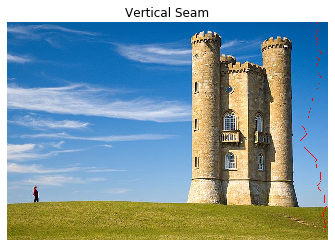

In [9]:
vcost, vpaths = compute_cost(img, energy)

# Vertical Backtracking
start = time()
end = np.argmin(vcost[-1])
seam_energy = vcost[-1, end]
seam_ = backtrack_seam(vpaths, end)
end = time()

print("Backtracking optimal seam: %f seconds." % (end - start))
print('Seam Energy:', seam_energy)

# Visualize seam
vseam = np.copy(img)
for row in range(vseam.shape[0]):
    vseam[row, seam_[row], :] = np.array([1.0, 0, 0])

plt.title('Vertical Seam')
plt.axis('off')
plt.imshow(vseam)
plt.show()

In the image above, the optimal vertical seam (minimal cost) goes through the portion of sky without any cloud, which yields the lowest energy.

---

### Reduce (25 points)

We can now use the function `backtrack` and `remove_seam` iteratively to reduce the size of the image through **seam carving**.

Each reduce can take around 10 seconds to compute, depending on your implementation.
If it's too long, try to vectorize your code in `compute_cost` to only use one loop.

In [10]:
from seam_carving import reduce

# Let's first test with a small example
test_img = np.arange(9, dtype=np.float64).reshape((3, 3))
test_img = np.stack([test_img, test_img, test_img], axis=2)
assert test_img.shape == (3, 3, 3)

cost = np.array([[1.0, 2.0, 1.5],
                 [4.0, 2.0, 3.5],
                 [6.0, 2.5, 5.0]])

paths = np.array([[ 0,  0,  0],
                  [ 0, -1,  0],
                  [ 1,  0, -1]])

out_remove_seam = np.asarray([[[1., 1., 1.],[2., 2., 2.]],\
                              [[3., 3., 3.],[5., 5., 5.]],\
                              [[6., 6., 6.],[8., 8., 8.]]])

# Reduce image width
W_new = 2

# We force the cost and paths to our values
out = reduce(test_img, W_new, cfunc=lambda x, y: (cost, paths), bfunc=lambda x,y: seam, rfunc=lambda x,y: out_remove_seam)

print("Original image (channel 0):")
print(test_img[:, :, 0])
print("Reduced image (channel 0): we see that seam [0, 4, 7] is removed")
print(out[:, :, 0])

assert np.allclose(out[:, :, 0], np.array([[1, 2], [3, 5], [6, 8]]))

Original image (channel 0):
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
Reduced image (channel 0): we see that seam [0, 4, 7] is removed
[[1. 2.]
 [3. 5.]
 [6. 8.]]


Reducing width from 640 to 400: 6.623538 seconds.


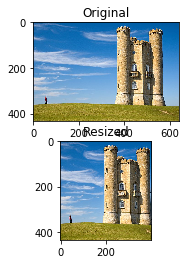

In [11]:
# Reduce image width
H, W, _ = img.shape
W_new = 400

start = time()
out = reduce(img, W_new)
end = time()

print("Reducing width from %d to %d: %f seconds." % (W, W_new, end - start))

plt.subplot(2, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

We observe that resizing from width 640 to width 400 conserves almost all the important part of the image (the person and the castle), where a standard resizing would have compressed everything.

All the vertical seams removed avoid the person and the castle.

Reducing height from 434 to 300: 4.442853 seconds.


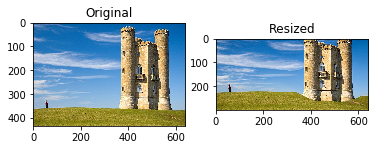

In [12]:
# Reduce image height
H, W, _ = img.shape
H_new = 300

start = time()
out = reduce(img, H_new, axis=0)
end = time()

print("Reducing height from %d to %d: %f seconds." % (H, H_new, end - start))

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

For reducing the height, we observe that the result does not look as nice.

The issue here is that the castle is on all the height of the image, so most horizontal seams will go through it.  
Interestingly, we observe that most of the grass is not removed. This is because the grass has small variation between neighboring pixels (in a kind of noisy pattern) that make it high energy.  
The seams removed go through the sky on the left, go under the castle to remove some grass and then back up in the low energy blue sky.

## Image Enlarging

### Enlarge naive (10 points)
We now want to tackle the reverse problem of enlarging an image.  
One naive way to approach the problem would be to duplicate the optimal seam iteratively until we reach the desired size.

In [13]:
from seam_carving import enlarge_naive

# Let's first test with a small example
test_img = np.arange(9, dtype=np.float64).reshape((3, 3))
test_img = np.stack([test_img, test_img, test_img], axis=2)
assert test_img.shape == (3, 3, 3)

cost = np.array([[1.0, 2.0, 1.5],
                 [4.0, 2.0, 3.5],
                 [6.0, 2.5, 5.0]])

paths = np.array([[ 0,  0,  0],
                  [ 0, -1,  0],
                  [ 1,  0, -1]])

out_duplicate_seam = np.asarray( [[[0., 0., 0.],[0., 0., 0.],[1., 1., 1.],[2., 2., 2.]],\
                                  [[3., 3., 3.],[4., 4., 4.],[4., 4., 4.],[5., 5., 5.]],\
                                  [[6., 6., 6.],[7., 7., 7.],[7., 7., 7.],[8., 8., 8.]]])

# Increase image width
W_new = 4

# We force the cost and paths to our values
out = enlarge_naive(test_img, W_new, cfunc=lambda x, y: (cost, paths), bfunc=lambda x,y: seam , dfunc=lambda x,y:out_duplicate_seam)

print("Original image (channel 0):")
print(test_img[:, :, 0])
print("Enlarged image (channel 0): we see that seam [0, 4, 7] is duplicated")
print(out[:, :, 0])

assert np.allclose(out[:, :, 0], np.array([[0, 0, 1, 2], [3, 4, 4, 5], [6, 7, 7, 8]]))

Original image (channel 0):
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
Enlarged image (channel 0): we see that seam [0, 4, 7] is duplicated
[[0. 0. 1. 2.]
 [3. 4. 4. 5.]
 [6. 7. 7. 8.]]


Enlarging(naive) width from 640 to 800: 5.300828 seconds.


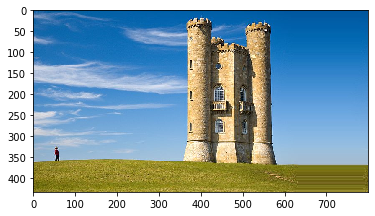

In [14]:
W_new = 800

# This is a naive implementation of image enlarging
# which iteratively computes energy function, finds optimal seam
# and duplicates it.
# This process will create a stretching artifact by choosing the same seam
start = time()
enlarged = enlarge_naive(img, W_new)
end = time()

# Can take around 20 seconds
print("Enlarging(naive) width from %d to %d: %f seconds." \
      % (W, W_new, end - start))

plt.imshow(enlarged)
plt.show()

The issue with `enlarge_naive` is that the same seam will be selected again and again, so this low energy seam will be the only to be duplicated.

Another way to get k different seams is to apply the process we used in function `reduce`, and keeping track of the seams we delete progressively.
The function `find_seams(image, k)` will find the top k seams for removal iteratively.

The inner workings of the function are a bit tricky so we've implemented it for you, but you should go into the code and understand how it works.  
This should also help you for the implementation of `enlarge`.

Finding 160 seams: 4.542071 seconds.


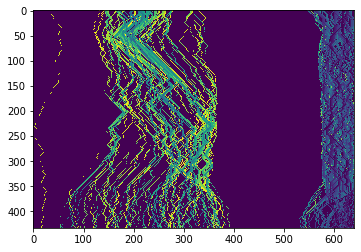

In [15]:
from seam_carving import find_seams

# Alternatively, find k seams for removal and duplicate them.
start = time()
seams = find_seams(img, W_new - W)
end = time()

# Can take around 10 seconds
print("Finding %d seams: %f seconds." % (W_new - W, end - start))

plt.imshow(seams, cmap='viridis')
plt.show()

### Enlarge (25 points)

We can see that all the seams found are different, and they avoid the castle and the person.

One issue we can mention is that we cannot enlarge more than we can reduce. Because of our process, the maximum enlargement is the width of the image `W` because we first need to find `W` different seams in the image.

One effect we can see on this image is that the blue sky at the right of the castle can only be enlarged x2. The concentration of seams in this area is very strong.  
We can also note that the seams at the right of the castle have a blue color, which means they have low value and were removed in priority in the seam selection process.

In [16]:
from seam_carving import enlarge

# Let's first test with a small example
test_img = np.array([[0.0, 1.0, 3.0],
                     [0.0, 1.0, 3.0],
                     [0.0, 1.0, 3.0]])
#test_img = np.arange(9, dtype=np.float64).reshape((3, 3))
test_img = np.stack([test_img, test_img, test_img], axis=2)
assert test_img.shape == (3, 3, 3)

# Increase image width
W_new = 5

out_naive = enlarge_naive(test_img, W_new)
out = enlarge(test_img, W_new)

print("Original image (channel 0):")
print(test_img[:, :, 0])
print("Enlarged naive image (channel 0): first seam is duplicated twice.")
print(out_naive[:, :, 0])
print("Enlarged image (channel 0): first and second seam are each duplicated once.")
print(out[:, :, 0])

assert np.allclose(out[:, :, 0], np.array([[0, 0, 1, 1, 3], [0, 0, 1, 1, 3], [0, 0, 1, 1, 3]]))

Original image (channel 0):
[[0. 1. 3.]
 [0. 1. 3.]
 [0. 1. 3.]]
Enlarged naive image (channel 0): first seam is duplicated twice.
[[0. 0. 0. 1. 3.]
 [0. 0. 0. 1. 3.]
 [0. 0. 0. 1. 3.]]
Enlarged image (channel 0): first and second seam are each duplicated once.
[[0. 0. 1. 1. 3.]
 [0. 0. 1. 1. 3.]
 [0. 0. 1. 1. 3.]]


Enlarging width from 640 to 800: 5.887159 seconds.


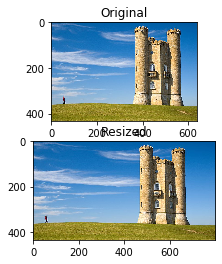

In [17]:
W_new = 800

start = time()
out = enlarge(img, W_new)
end = time()

# Can take around 20 seconds
print("Enlarging width from %d to %d: %f seconds." \
      % (W, W_new, end - start))

plt.subplot(2, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

Finding 160 seams: 6.195623 seconds.


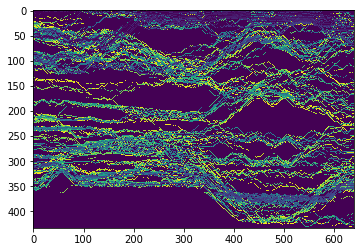

In [18]:
# Map of the seams for horizontal seams.
start = time()
seams = find_seams(img, W_new - W, axis=0)
end = time()

# Can take around 15 seconds
print("Finding %d seams: %f seconds." % (W_new - W, end - start))

plt.imshow(seams, cmap='viridis')
plt.show()

Enlarging height from 434 to 600: 8.439018 seconds.


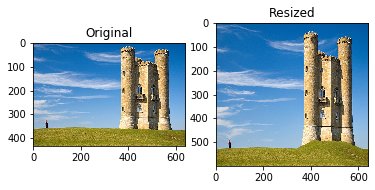

In [19]:
H_new = 600

start = time()
out = enlarge(img, H_new, axis=0)
end = time()

# Can take around 20 seconds
print("Enlarging height from %d to %d: %f seconds." \
      % (H, H_new, end - start))

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

As you can see in the example above, the sky above the castle has doubled in size, the grass below has doubled in size but we still can't reach a height of 600.  
The algorithm then needs to enlarge the castle itself, while trying to avoid enlarging the windows for instance.

## Other experiments on the image

Feel free to experiment more on this image, try different sizes to enlarge or reduce, or check what seams are chosen...

Reducing by a 2x factor often leads to weird patterns.  
Enlarging by more than 2x is impossible since we only duplicate seams. One solution is to enlarge in mutliple steps (enlarge x1.4, enlarge again x1.4...)

Reducing width from 640 to 200: 10.235845 seconds.


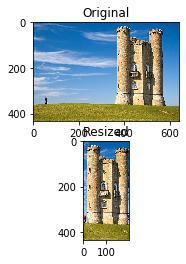

In [20]:
# Reduce image width
H, W, _ = img.shape
W_new = 200

start = time()
out = reduce(img, W_new)
end = time()

print("Reducing width from %d to %d: %f seconds." % (W, W_new, end - start))

plt.subplot(2, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

## Extra Credit: Faster `reduce`

Implement a faster version of `reduce` called `reduce_fast` in the file `seam_carving.py`.

We will have a leaderboard on gradescope with the performance of students.  

The autograder tests will check that the outputs match, and run the `reduce_fast` function on a set of images with varying shapes (say between 200 and 800).

This extra credit can be worth up to 1% of your final grade.

Normal reduce width from 640 to 400: 6.135526 seconds.
Faster reduce width from 640 to 400: 6.146476 seconds.


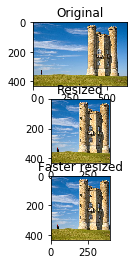

In [21]:
from seam_carving import reduce_fast

# Reduce image width
H, W, _ = img.shape
W_new = 400

start = time()
out = reduce(img, W_new)
end = time()

print("Normal reduce width from %d to %d: %f seconds." % (W, W_new, end - start))

start = time()
out_fast = reduce_fast(img, W_new)
end = time()

print("Faster reduce width from %d to %d: %f seconds." % (W, W_new, end - start))

assert np.allclose(out, out_fast), "Outputs don't match."


plt.subplot(3, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(3, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.subplot(3, 1, 3)
plt.title('Faster resized')
plt.imshow(out)

plt.show()

## Reducing and enlarging on another image

Also check these outputs with another image.

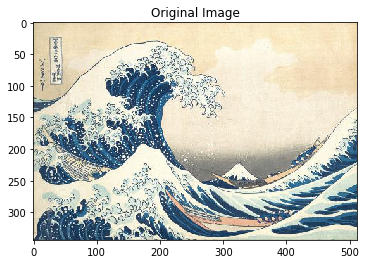

In [22]:
# Load image
img2 = io.imread('imgs/wave.jpg')
img2 = util.img_as_float(img2)

plt.title('Original Image')
plt.imshow(img2)
plt.show()

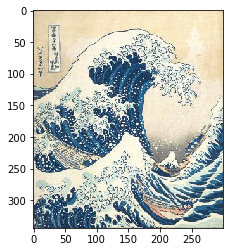

In [23]:
out = reduce(img2, 300)
plt.imshow(out)
plt.show()

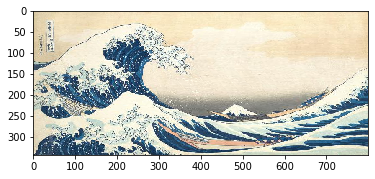

In [24]:
out = enlarge(img2, 800)
plt.imshow(out)
plt.show()

## Forward Energy (20 points)

Forward energy is a solution to some artifacts that appear when images have curves for instance.

Implement the function `compute_forward_cost`. This function will replace the `compute_cost` we have been using until now.

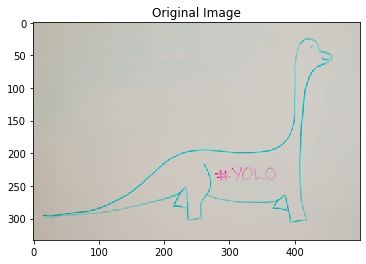

In [25]:
# Load image
img_yolo = io.imread('imgs/yolo.jpg')
img_yolo = util.img_as_float(img_yolo)

plt.title('Original Image')
plt.imshow(img_yolo)
plt.show()

In [27]:
from seam_carving import compute_forward_cost

# Let's first test with a small example
img_test = np.array([[1.0, 1.0, 2.0],
                     [0.5, 0.0, 0.0],
                     [1.0, 0.5, 2.0]])
img_test = np.stack([img_test]*3, axis=2)
assert img_test.shape == (3, 3, 3)

energy = energy_function(img_test)

solution_cost = np.array([[0.5, 2.5, 3.0],
                          [1.0, 2.0, 3.0],
                          [2.0, 4.0, 6.0]])

solution_paths = np.array([[ 0,  0,  0],
                           [ 0, -1,  0],
                           [ 0, -1, -1]])

# Vertical Cost Map
vcost, vpaths = compute_forward_cost(img_test, energy)  # don't need the first argument for compute_cost

print("Image:")
print(color.rgb2grey(img_test))

print("Energy:")
print(energy)

print("Cost:")
print(vcost)
print("Solution cost:")
print(solution_cost)

print("Paths:")
print(vpaths)
print("Solution paths:")
print(solution_paths)

assert np.allclose(solution_cost, vcost)
assert np.allclose(solution_paths, vpaths)

Image:
[[1.  1.  2. ]
 [0.5 0.  0. ]
 [1.  0.5 2. ]]
Energy:
[[0.5 1.5 3. ]
 [0.5 0.5 0. ]
 [1.  1.  3.5]]
Cost:
[[0.5 2.5 3. ]
 [1.  2.  3. ]
 [2.  4.  6. ]]
Solution cost:
[[0.5 2.5 3. ]
 [1.  2.  3. ]
 [2.  4.  6. ]]
Paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 0 -1 -1]]
Solution paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 0 -1 -1]]


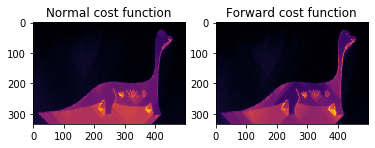

In [29]:
from seam_carving import compute_forward_cost

energy = energy_function(img_yolo)

out, _ = compute_cost(img_yolo, energy)
plt.subplot(1, 2, 1)
plt.imshow(out, cmap='inferno')
plt.title("Normal cost function")

out, _ = compute_forward_cost(img_yolo, energy)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='inferno')
plt.title("Forward cost function")

plt.show()

We observe that the forward energy insists more on the curved edges of the image.

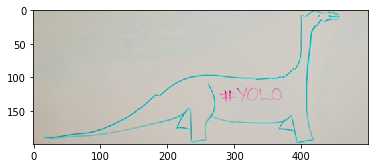

In [28]:
from seam_carving import reduce
out = reduce(img_yolo, 200, axis=0)
plt.imshow(out)
plt.show()

The issue with our standard `reduce` function is that it removes vertical seams without any concern for the energy introduced in the image.

In the case of the dinosaure above, the continuity of the shape is broken. The head is totally wrong for instance, and the back of the dinosaure lacks continuity.

**Forward energy** will solve this issue by explicitely putting high energy on a seam that breaks this continuity and introduces energy.

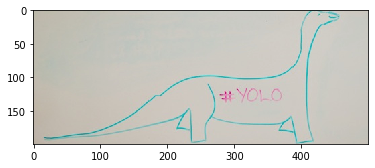

In [30]:
# This step can take a very long time depending on your implementation.
out = reduce(img_yolo, 200, axis=0, cfunc=compute_forward_cost)
plt.imshow(out)
plt.show()

## Extra Credit: Object Removal

Object removal uses a binary mask of the object to be removed.

Using the `reduce` and `enlarge` functions you wrote before, complete the function `remove_object` to output an image of the same shape but without the object to remove.

This extra credit can be worth up to 1% of your final grade. 

In [ ]:
# Load image
image = io.imread('imgs/wyeth.jpg')
image = util.img_as_float(image)

mask = io.imread('imgs/wyeth_mask.jpg', as_grey=True)
mask = util.img_as_bool(mask)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Mask of the object to remove')
plt.imshow(mask)

plt.show()

In [30]:
from seam_carving import remove_object

# Use your function to remove the object
out = remove_object(image, mask)

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(2, 2, 2)
plt.title('Mask of the object to remove')
plt.imshow(mask)

plt.subplot(2, 2, 3)
plt.title('Image with object removed')
plt.imshow(out)

plt.show()